In [1]:
Sys.setenv(RETICULATE_PYTHON = "/home/gonglihao/miniconda3/envs/42/bin/python")
suppressPackageStartupMessages({
    library("dplyr")
    library("Matrix")
    library("Seurat")
    library("SeuratWrappers")
    library("tictoc")
    library("ggplot2")
    library("ggpubr")
    library("future")
    library("SingleR")
    library("pheatmap")
})

In [2]:
load("/data3/Group8/gonglihao/1-MMP9/1-QC/shNC.rda")
load("/data3/Group8/gonglihao/1-MMP9/1-QC/shNC(multiplets).rda")

In [3]:
putative_singlets<-setdiff(colnames(seu), putative_doublets)
seu<-subset(seu, cells=putative_singlets)

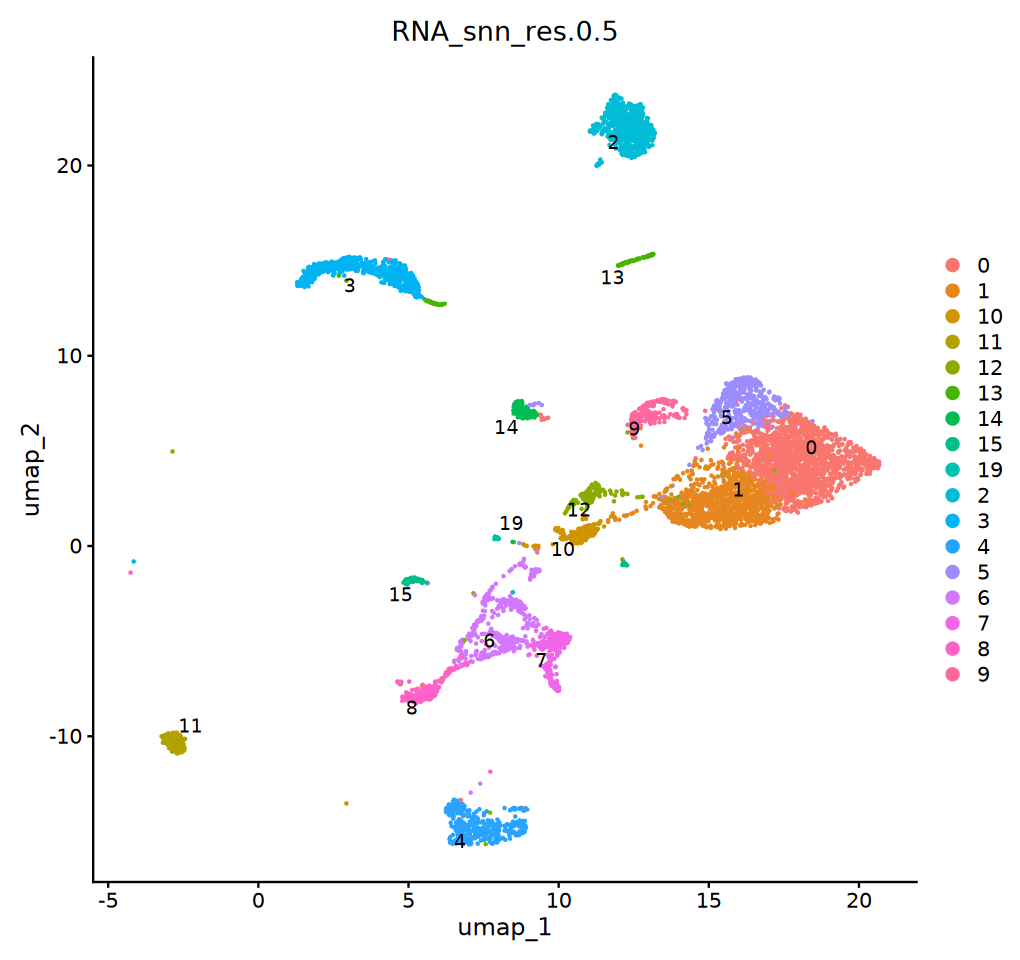

In [4]:
options(repr.plot.width=8.5, repr.plot.height=8)
UMAPPlot(seu, group.by="RNA_snn_res.0.5", label=T, repel=T)

14 NK
2 B 
11  Hepatocytes  #Fabp1 
13 Neutrophils
19 Mast cells

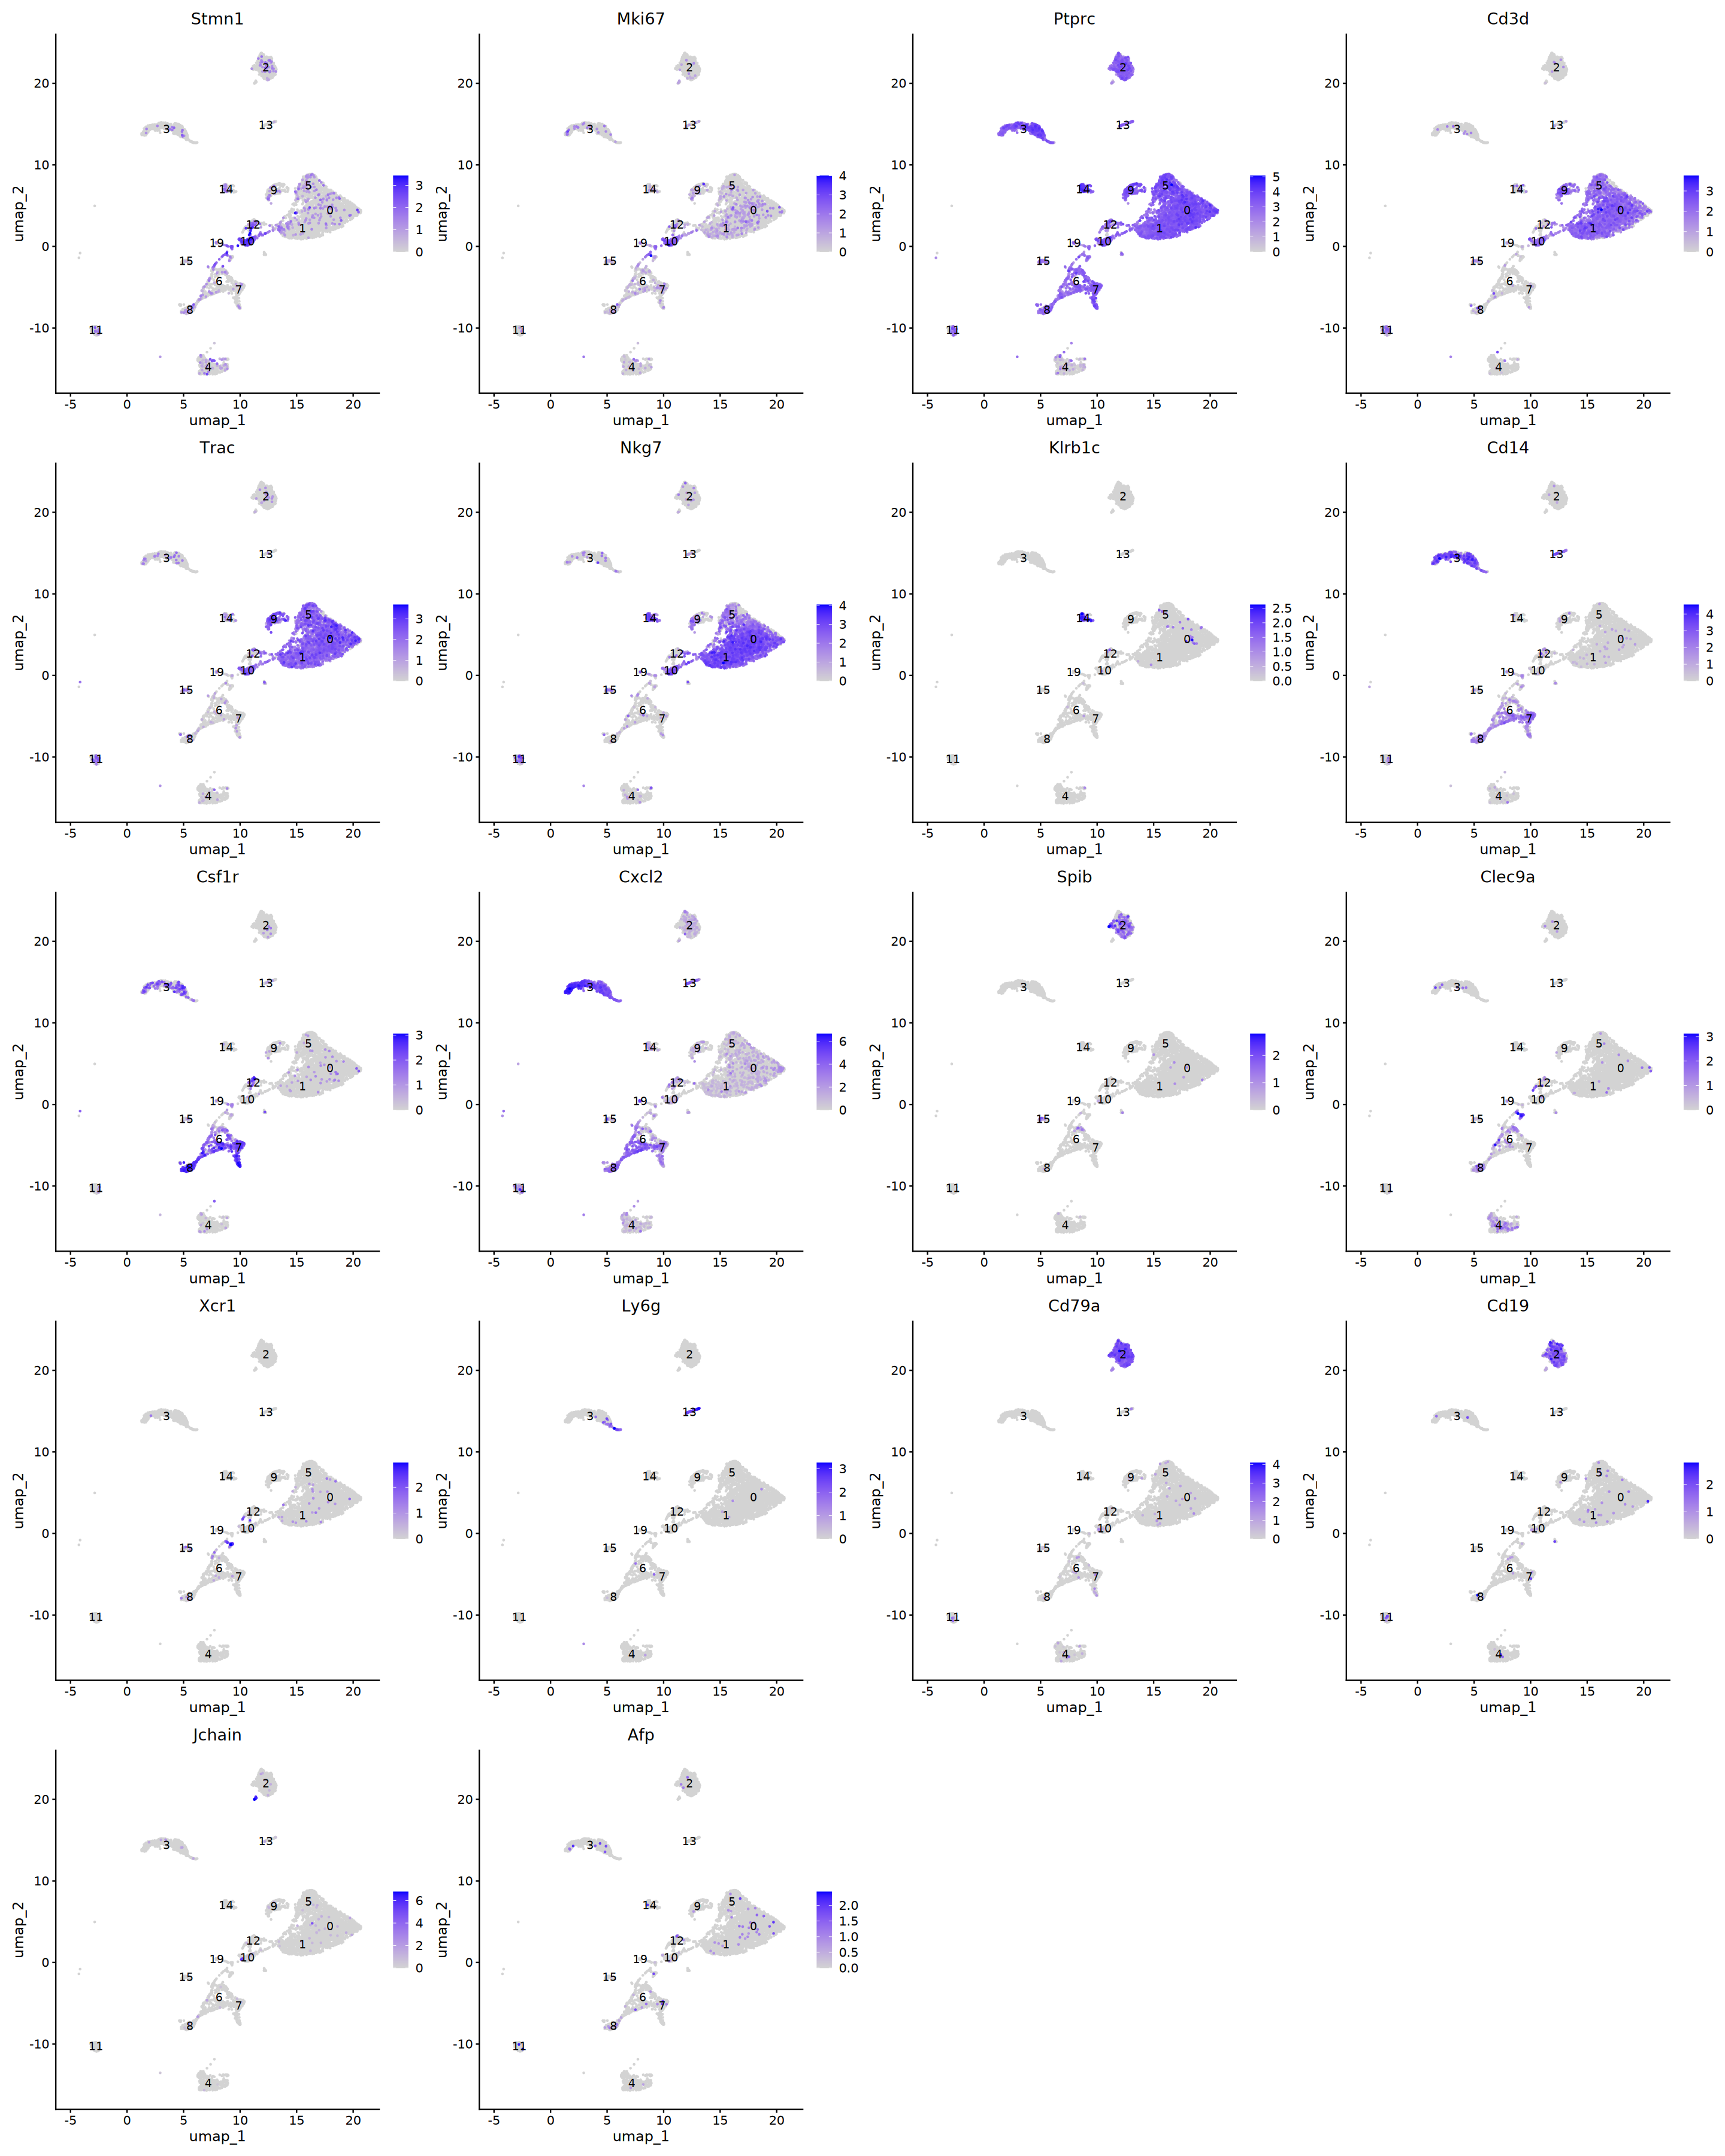

In [13]:
options(repr.plot.width=6*4, repr.plot.height=6*5,repe.plot.resolution=300)
FeaturePlot(seu, ncol=4, label=T,  order = TRUE,
            features = c("Stmn1","Mki67","Ptprc","Cd3d","Trac","Nkg7","Klrb1c","Cd14","Csf1r","Cxcl2","Spib","Clec9a","Xcr1","Ly6g","Cd79a","Cd19","Jchain","Afp"))

In [20]:
library(COSG)
library(writexl)

output_path <- "/data3/Group8/gonglihao/1-MMP9/1-QC"
cluster_col <- "RNA_snn_res.0.5"

Idents(seu) <- cluster_col

cosg_markers <- cosg(
   seu,
   groups = 'all',
   mu = 1
)

avg_expr <- AggregateExpression(
   seu,
   group.by = cluster_col,
   assays = "RNA"
)$RNA

cluster_vec <- rep(names(cosg_markers$names), sapply(cosg_markers$names, length))
genes_vec <- unlist(cosg_markers$names)
scores_vec <- unlist(cosg_markers$scores)

cosg_results_df <- data.frame(
   cluster = cluster_vec,
   Gene = genes_vec,
   Score = scores_vec,
   stringsAsFactors = FALSE
)

cluster_names <- paste0("g", cosg_results_df$cluster)
cosg_results_df$Avg_Expression <- NA

genes_match <- match(cosg_results_df$Gene, rownames(avg_expr))
clusters_match <- match(cluster_names, colnames(avg_expr))
valid_indices <- !is.na(genes_match) & !is.na(clusters_match)
cosg_results_df$Avg_Expression[valid_indices] <- round(
   avg_expr[cbind(
       genes_match[valid_indices], 
       clusters_match[valid_indices]
   )],
   3
)

cosg_results_df$cluster <- as.numeric(cosg_results_df$cluster)
cosg_results_df <- cosg_results_df[order(cosg_results_df$cluster, -cosg_results_df$Score),]

excel_data <- split(cosg_results_df, cosg_results_df$cluster)
excel_data <- lapply(excel_data, function(x) {
   x <- x[order(-x$Score),]
   x$cluster <- NULL
   return(x)
})
names(excel_data) <- paste0("Cluster", names(excel_data))

resolution <- sub(".*res\\.", "", cluster_col)

excel_filename <- paste0("cosg_markers-", resolution, ".xlsx")
csv_filename <- paste0("cosg_markers-", resolution, ".csv")

write_xlsx(excel_data, path = file.path(output_path, excel_filename))
data.table::fwrite(cosg_results_df, file = file.path(output_path, csv_filename))

Warning message:
“x or y has vectors with all zero; consider setting use_nan = TRUE to set these values to NaN or use_nan = FALSE to suppress this warning”


In [7]:
tic()
ref <- celldex::ImmGenData()
mat <- GetAssayData(seu, layer="data")
pred.immgen.fine <- SingleR(test = mat, ref = ref, labels = ref$label.fine)
pred.immgen.main <- SingleR(test = mat, ref = ref, labels = ref$label.main)
toc()

seu[["pred.immgen.fine"]]      <-pred.immgen.fine$labels
seu[["pred.immgen.finepruned"]]<-pred.immgen.fine$pruned.labels

seu[["pred.immgen.main"]]      <-pred.immgen.main$labels
seu[["pred.immgen.mainpruned"]]<-pred.immgen.main$pruned.labels

297.964 sec elapsed


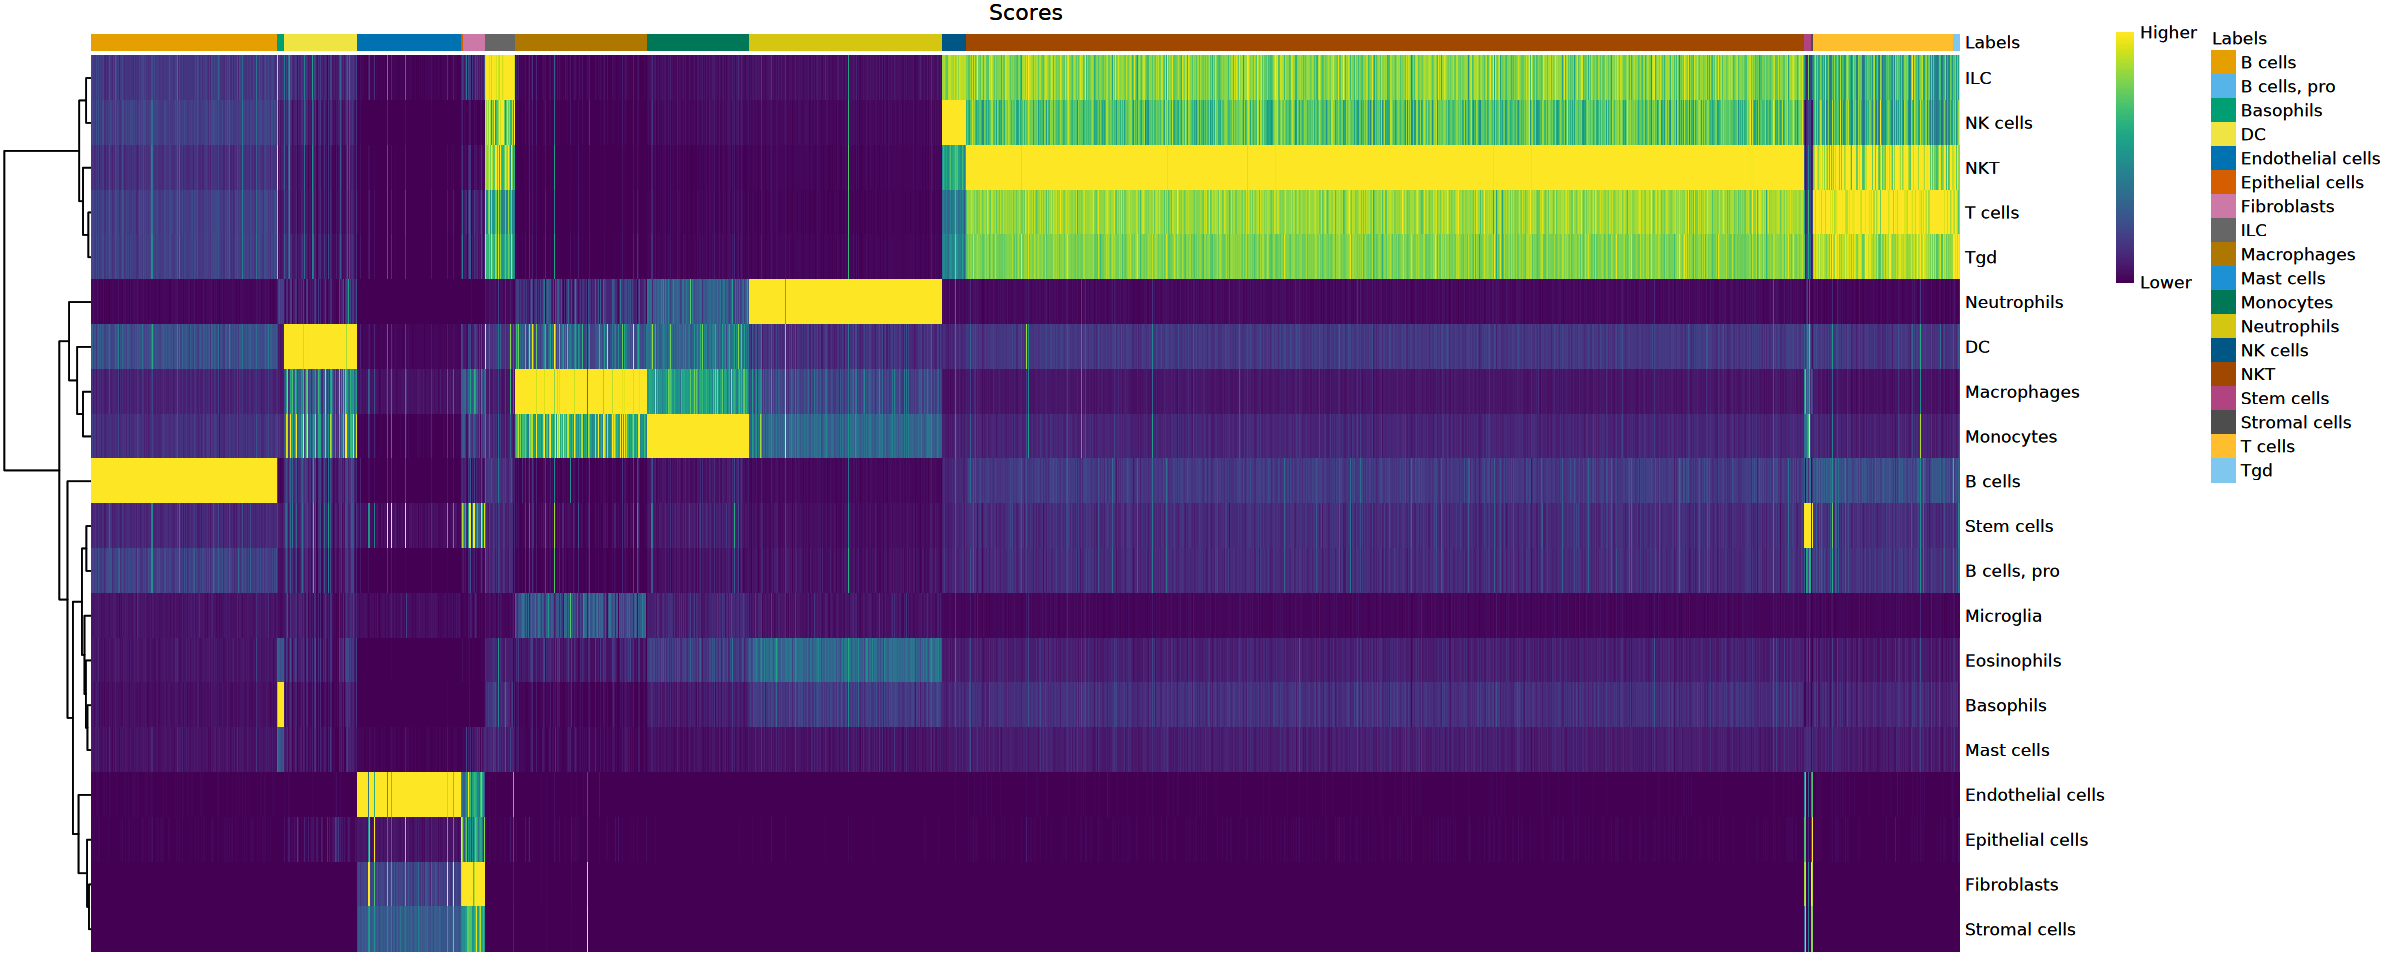

In [8]:
options(repr.plot.width=20, repr.plot.height=8)
plotScoreHeatmap(pred.immgen.main)

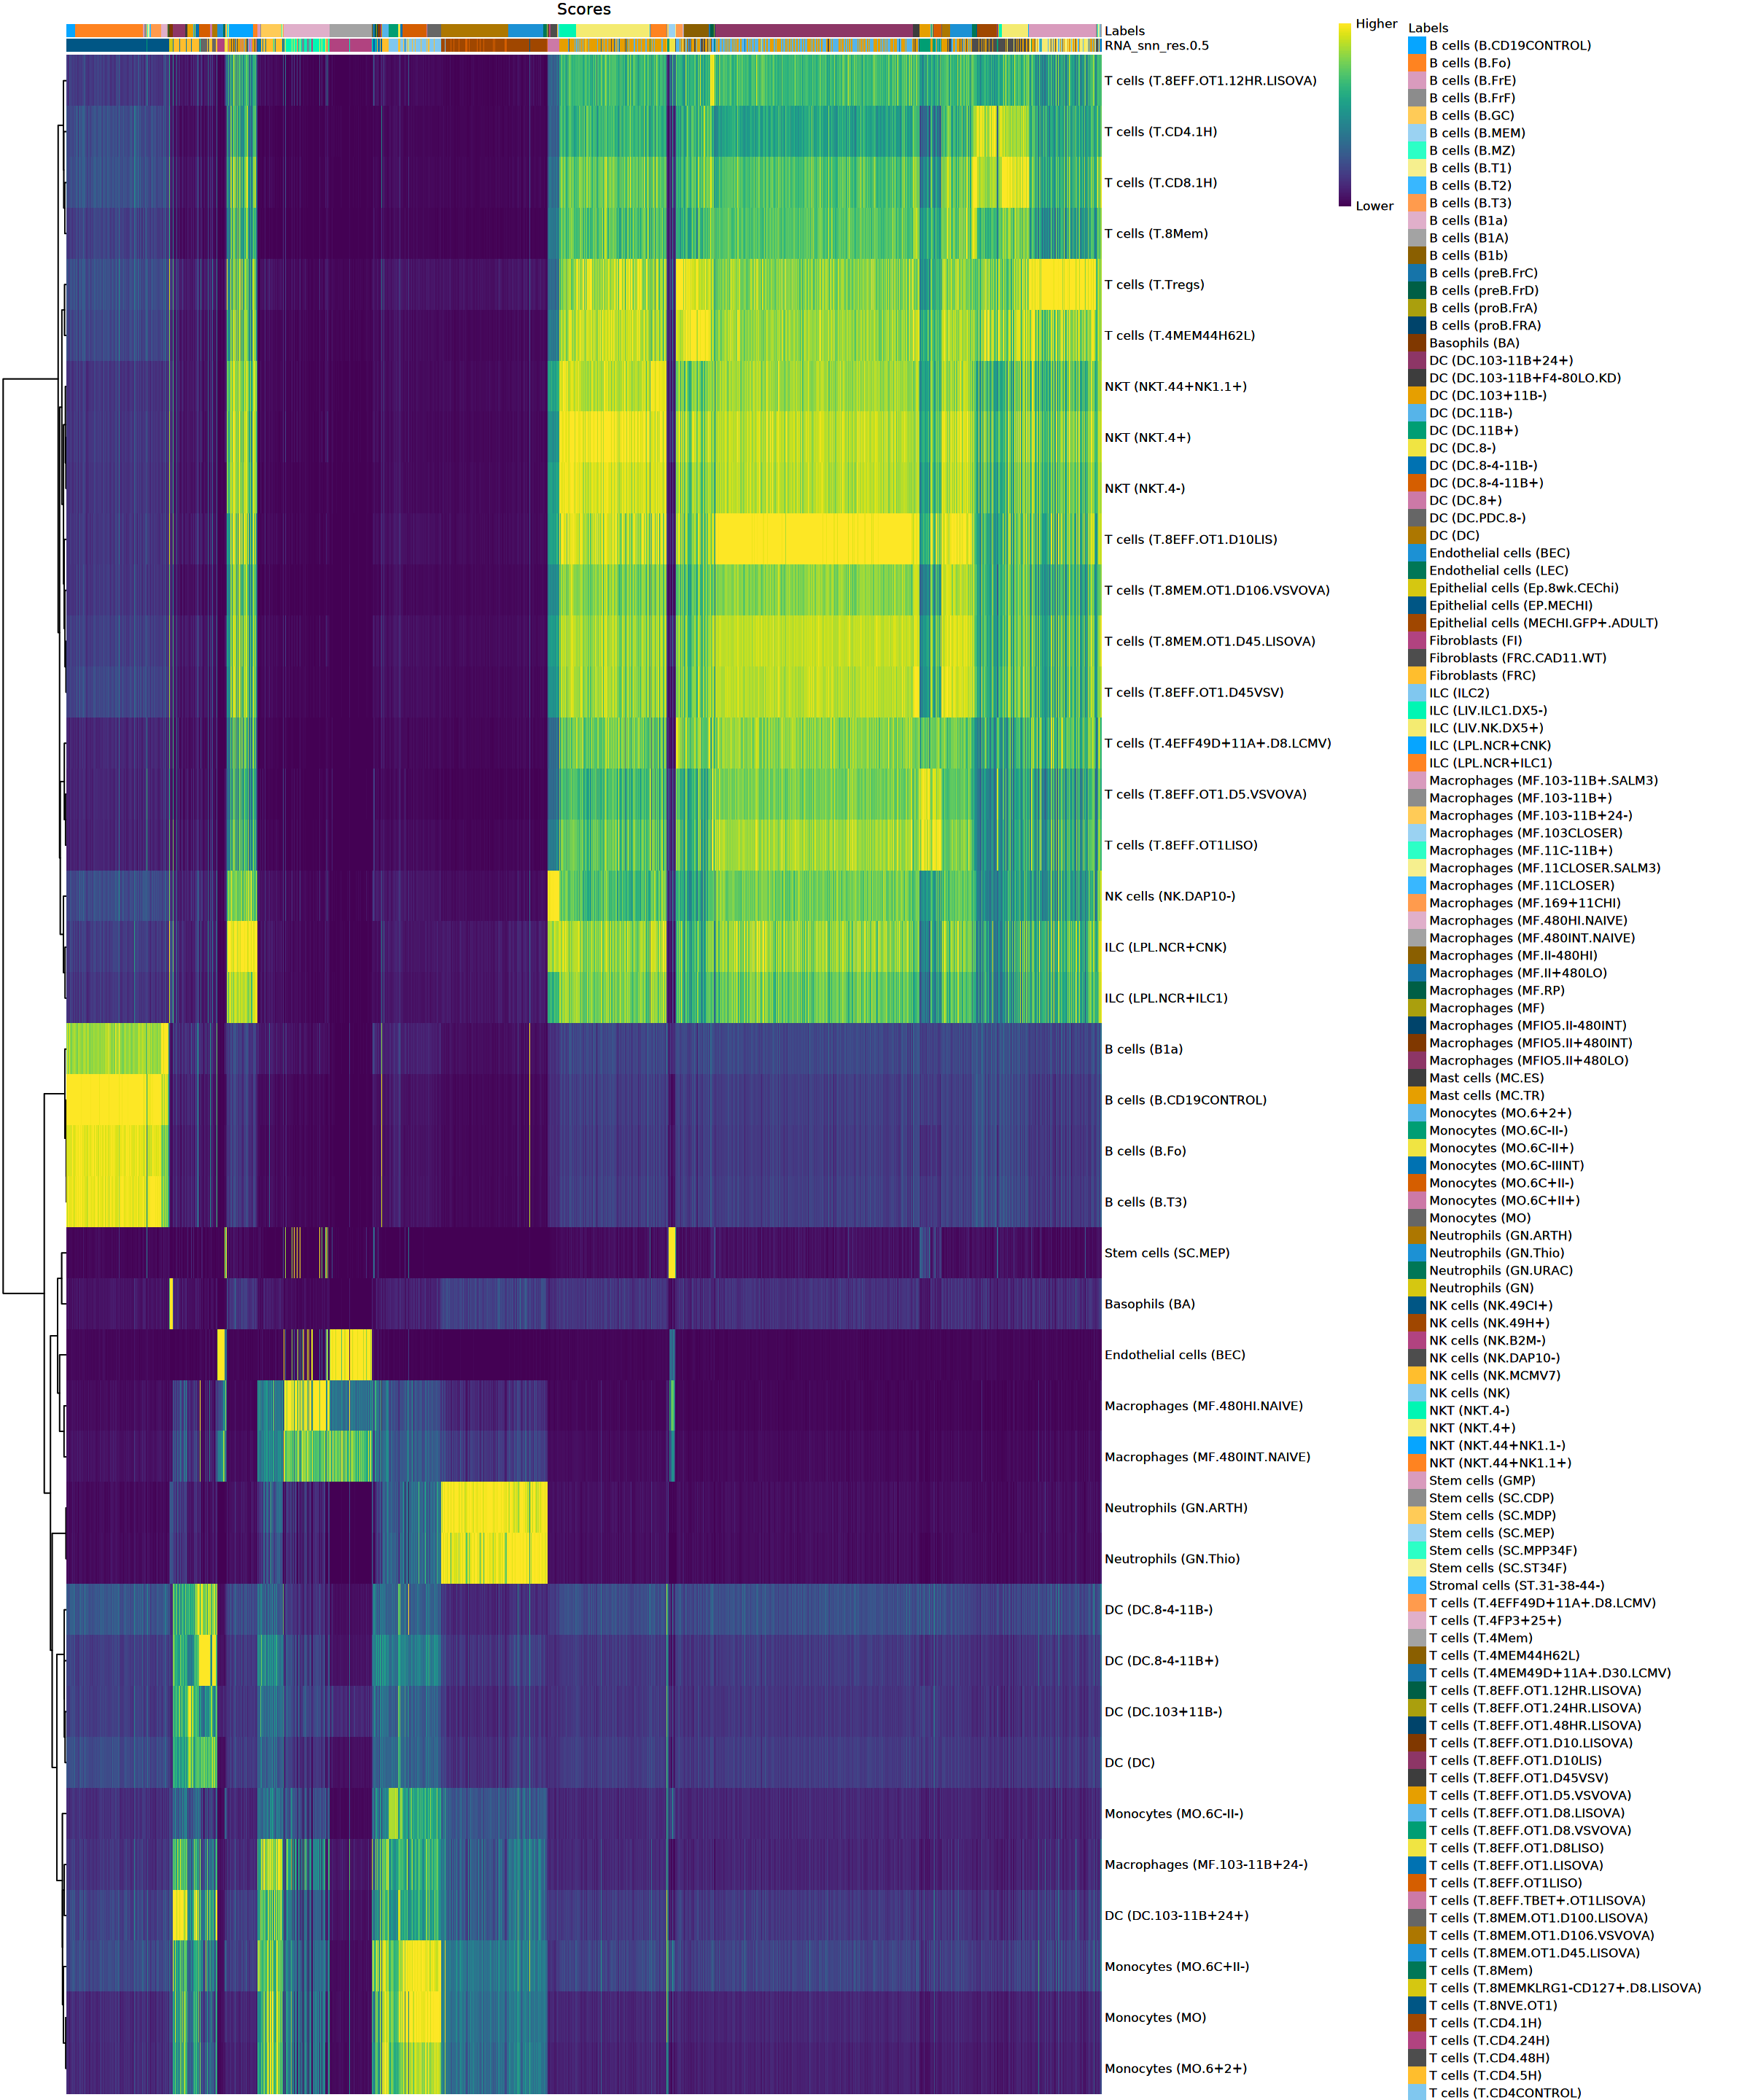

In [9]:
options(repr.plot.width=20, repr.plot.height=24)
plotScoreHeatmap(pred.immgen.fine,annotation_col=as.data.frame(seu[["RNA_snn_res.0.5"]]) )

In [10]:
seu[["pred.immgen.fine"]]      <-pred.immgen.fine$labels
seu[["pred.immgen.finepruned"]]<-pred.immgen.fine$pruned.labels

seu[["pred.immgen.main"]]      <-pred.immgen.main$labels
seu[["pred.immgen.mainpruned"]]<-pred.immgen.main$pruned.labels

Warning message:
“Removed 3746 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“Removed 3746 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


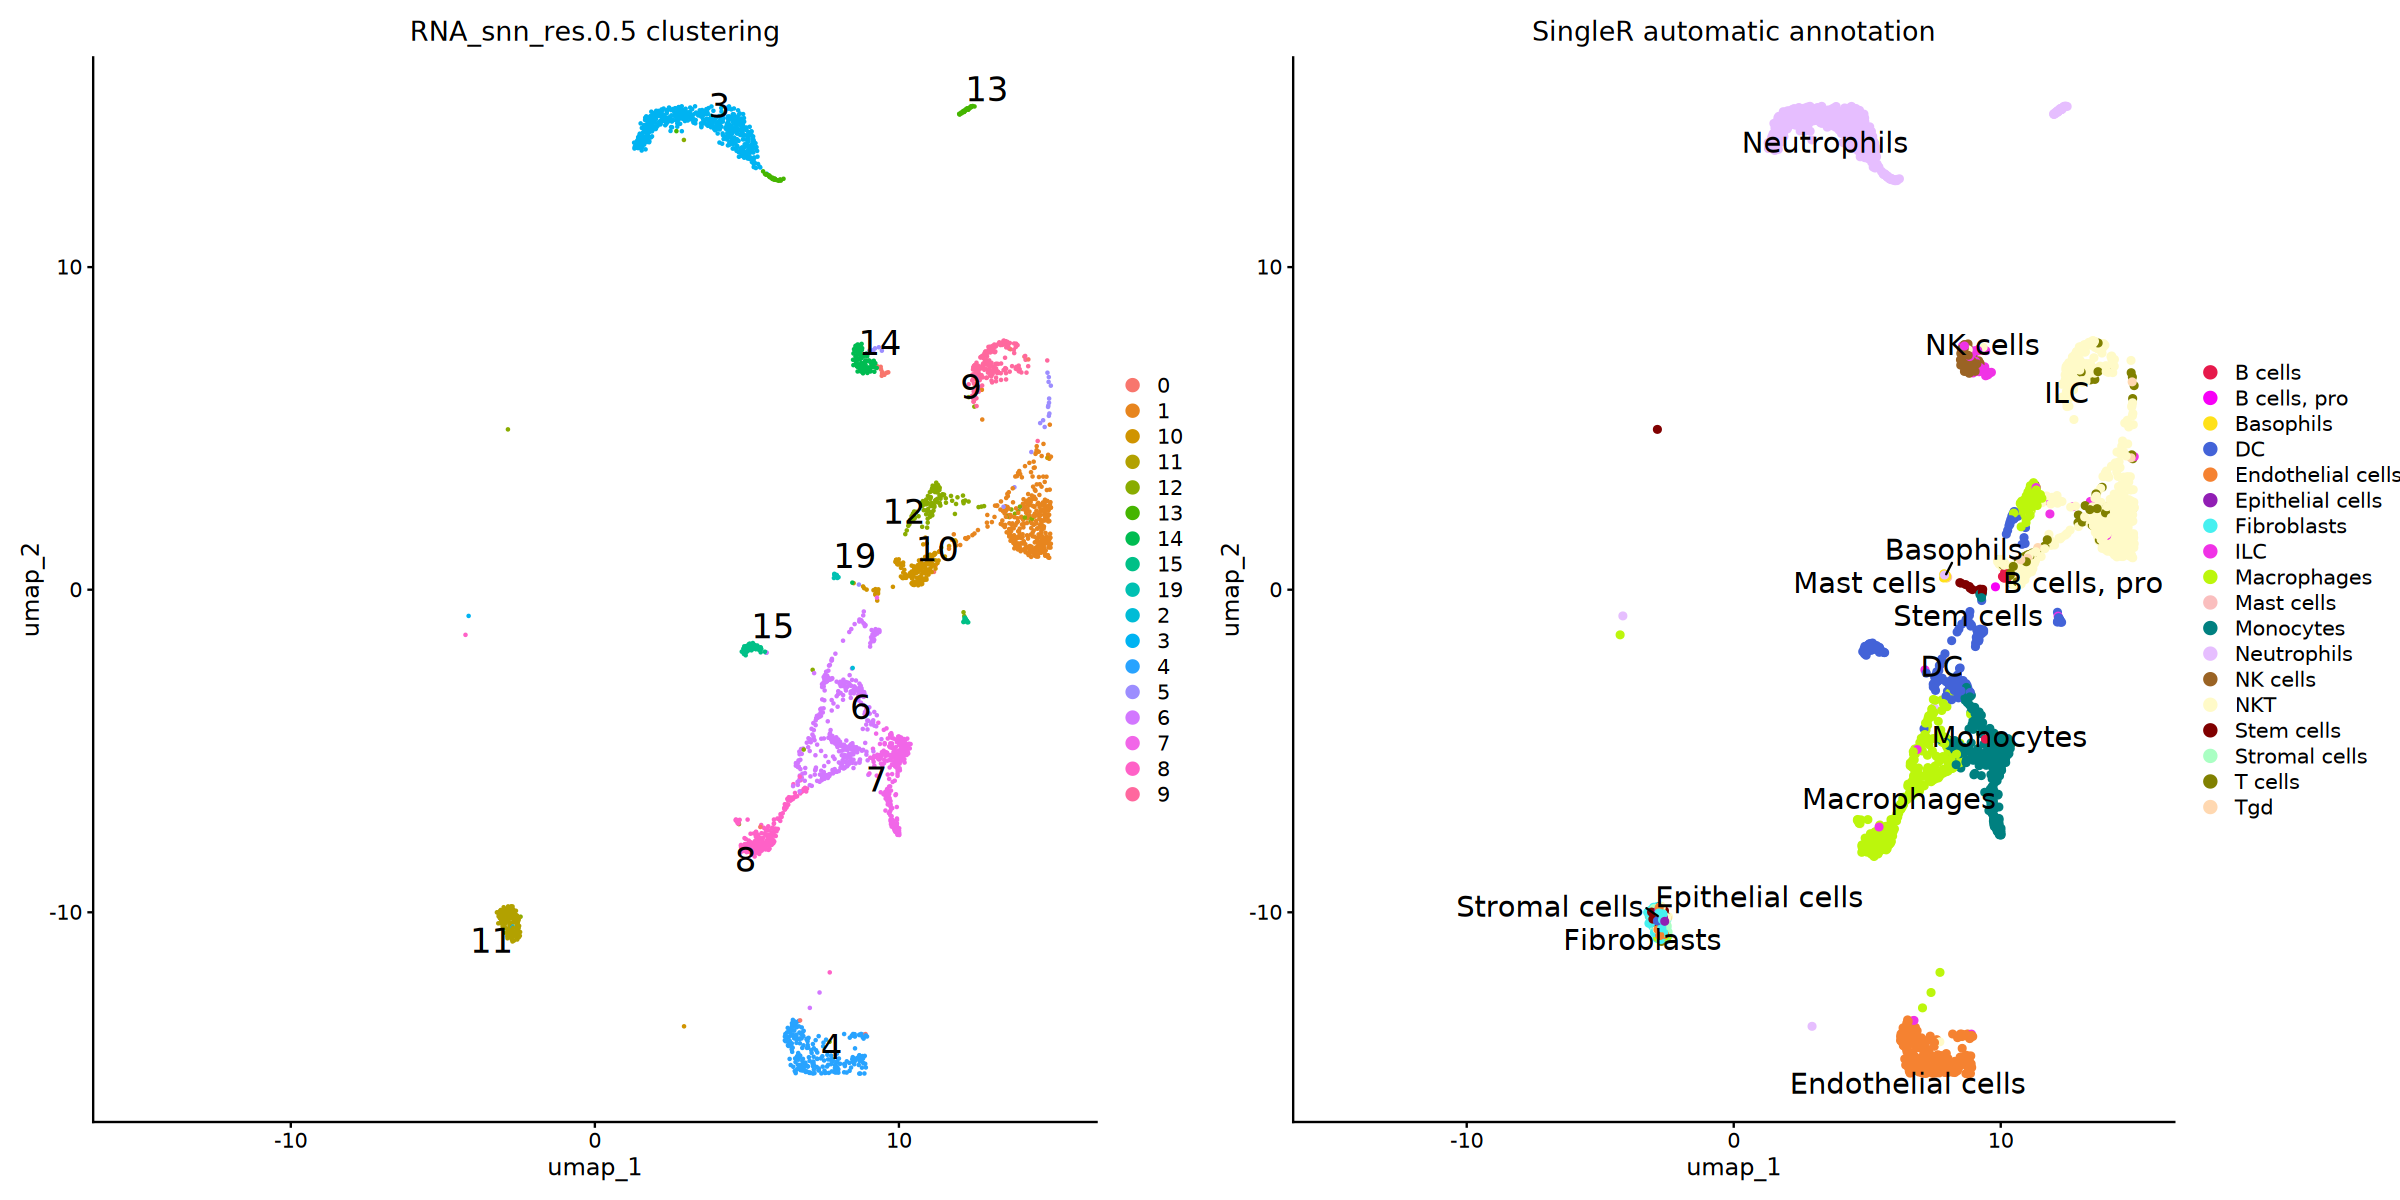

In [11]:
options(repr.plot.width=20, repr.plot.height=10)

Idents(seu)<-"RNA_snn_res.0.5"
ggarrange(
    UMAPPlot(seu, 
             group.by="RNA_snn_res.0.5", label=T, repel=T, label.size=7)+xlim(-15,15)+ylim(-15,15)+theme(legend.position = "right")+
    ggtitle("RNA_snn_res.0.5 clustering"),
    
    DimPlot(seu, 
         group.by="pred.immgen.main", label.size=6, 
         cols=c('#e6194b', '#F700F7', '#ffe119', '#4363d8', '#f58231', 
                '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#4f34ff', '#f340F0'), 
         pt.size=1.5,label=T, repel=T)+xlim(-15,15)+ylim(-15,15)+theme(legend.position ="right")+
    ggtitle("SingleR automatic annotation"), 
    ncol=2, nrow=1
)

In [21]:
options(warn=-1)
tic()
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)
plan("sequential")
seu <- ScaleData(seu,  features=rownames(seu), block.size = 1000, min.cells.to.block = 1000)
plan("sequential")
toc()

tic()
seu <- RunPCA(seu, npcs=30, verbose = FALSE)
seu <- RunUMAP(seu, dims = 1:30, umap.method = "umap-learn", metric = "correlation", verbose = FALSE)
toc()

tic()
seu <- FindNeighbors(object = seu, dims = 1:30,verbose=FALSE)
seu <- FindClusters( object = seu, resolution = c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),verbose=FALSE)
toc()

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



21.228 sec elapsed
93.654 sec elapsed
9.305 sec elapsed


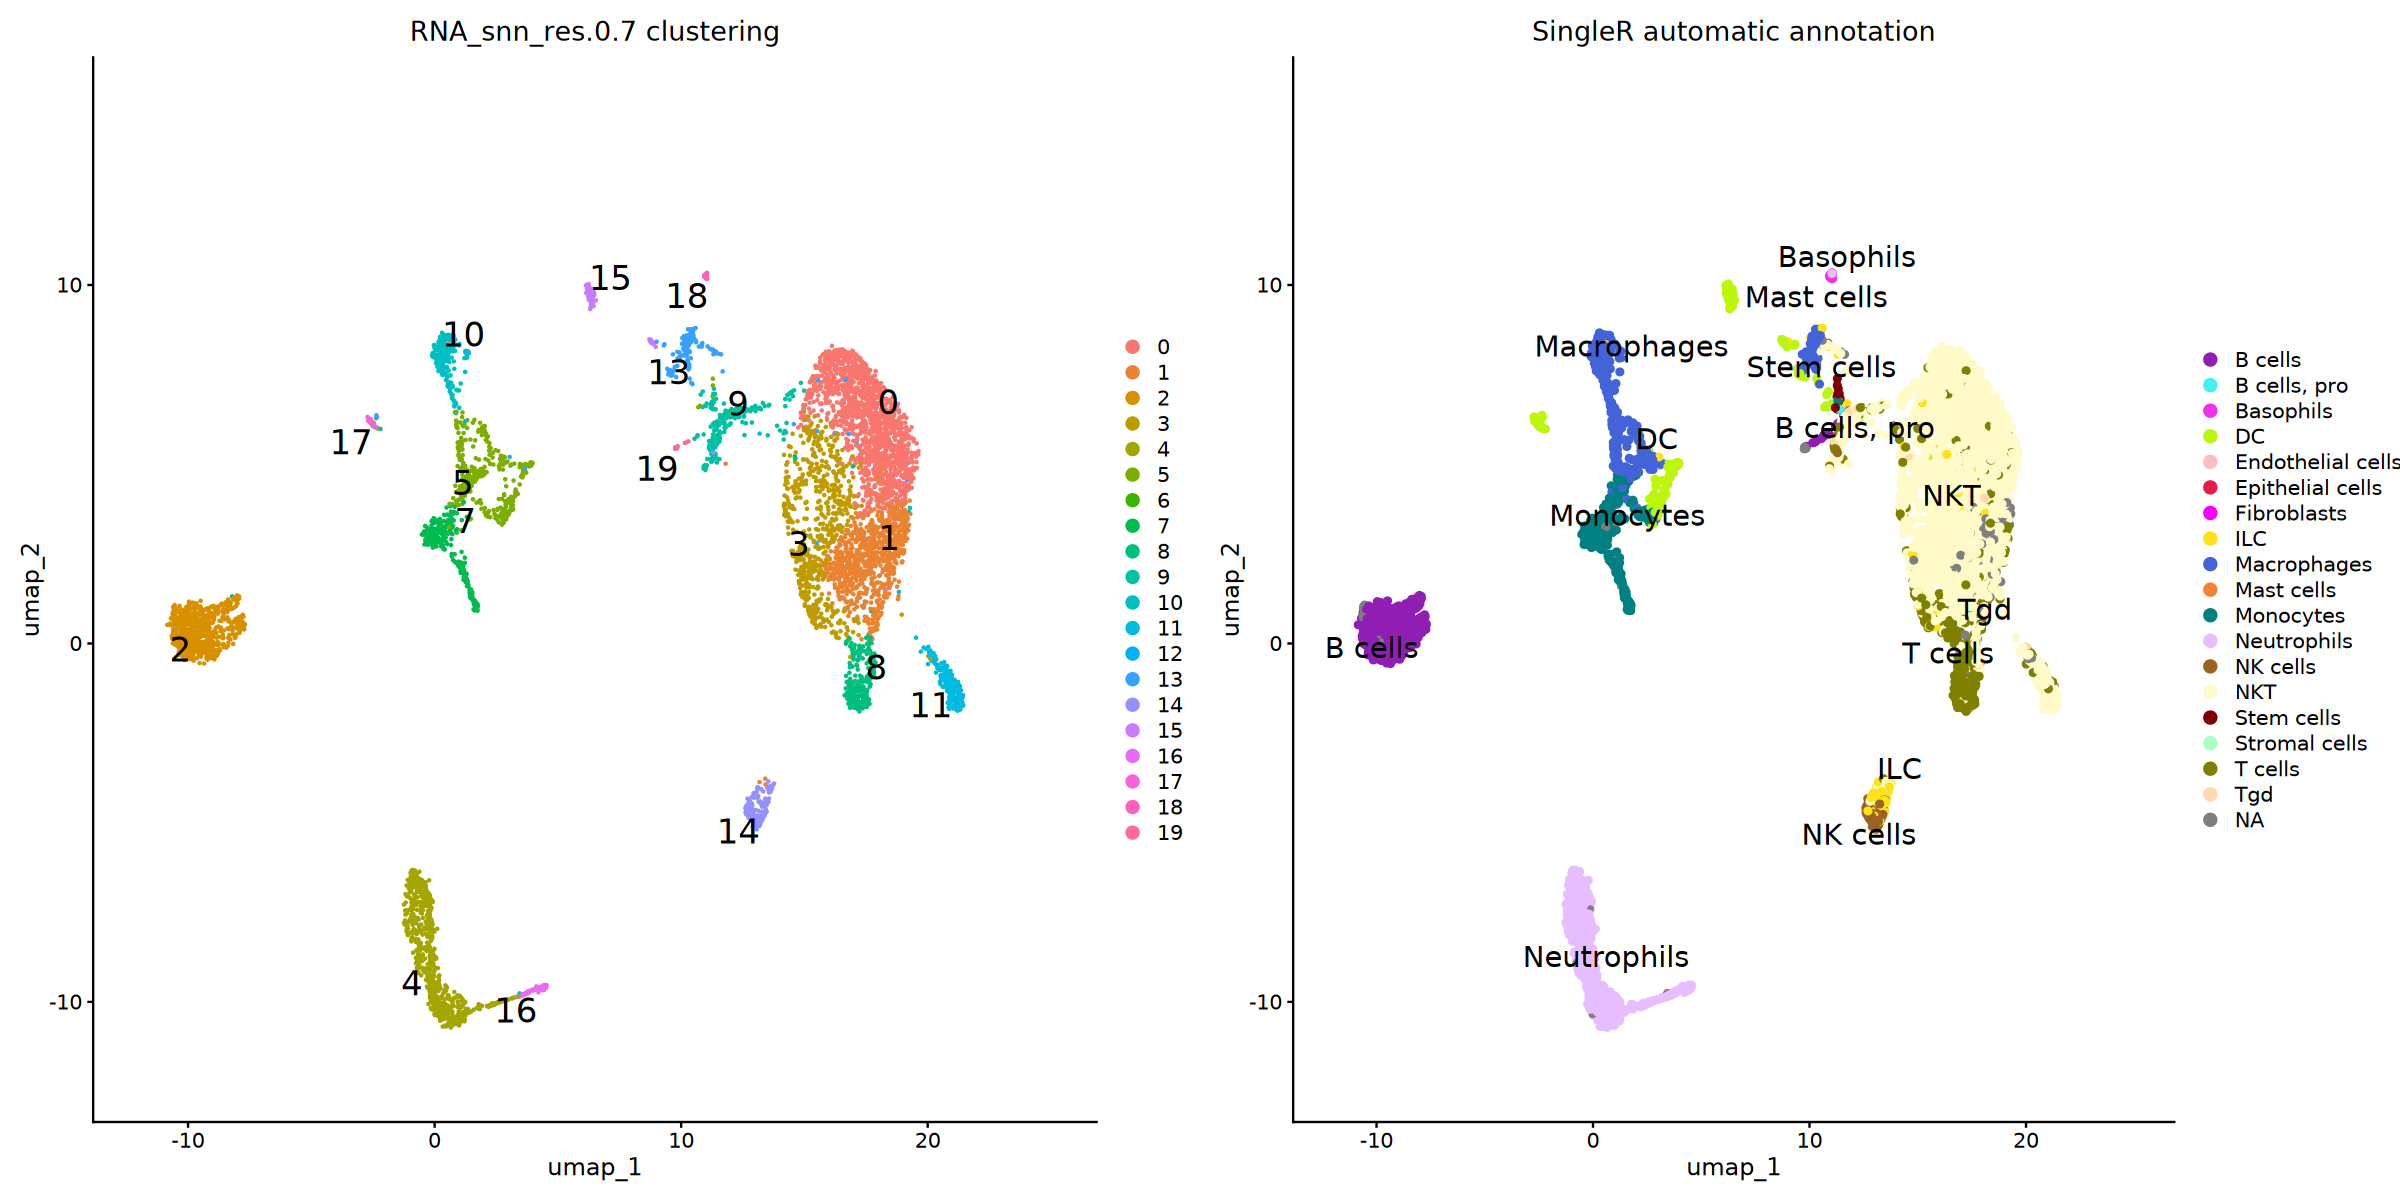

In [39]:
options(repr.plot.width=20, repr.plot.height=10)

Idents(seu)<-"RNA_snn_res.0.7"
ggarrange(
    UMAPPlot(seu, 
             group.by="RNA_snn_res.0.7", label=T, repel=T, label.size=7)+xlim(-12,25)+ylim(-12,15)+theme(legend.position = "right")+
    ggtitle("RNA_snn_res.0.7 clustering"),
    
    DimPlot(seu, 
         group.by="pred.immgen.mainpruned", label.size=6, 
         cols=c('#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                '#e6194b', '#F700F7', '#ffe119', '#4363d8', '#f58231',
                '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#4f34ff', '#f340F0'), 
         pt.size=1.5,label=T, repel=T)+xlim(-12,25)+ylim(-12,15)+theme(legend.position ="right")+
    ggtitle("SingleR automatic annotation"), 
    ncol=2, nrow=1
)

18 Mast cells
15 Ccl22 cDC2
17 Xcr1 cDC1
19 Plasma 


In [38]:
cluster_col <- "RNA_snn_res.0.7"

Idents(seu) <- cluster_col

cosg_markers <- cosg(
   seu,
   groups = 'all',
   mu = 1
)

avg_expr <- AggregateExpression(
   seu,
   group.by = cluster_col,
   assays = "RNA"
)$RNA

cluster_vec <- rep(names(cosg_markers$names), sapply(cosg_markers$names, length))
genes_vec <- unlist(cosg_markers$names)
scores_vec <- unlist(cosg_markers$scores)

cosg_results_df <- data.frame(
   cluster = cluster_vec,
   Gene = genes_vec,
   Score = scores_vec,
   stringsAsFactors = FALSE
)

cluster_names <- paste0("g", cosg_results_df$cluster)
cosg_results_df$Avg_Expression <- NA

genes_match <- match(cosg_results_df$Gene, rownames(avg_expr))
clusters_match <- match(cluster_names, colnames(avg_expr))
valid_indices <- !is.na(genes_match) & !is.na(clusters_match)
cosg_results_df$Avg_Expression[valid_indices] <- round(
   avg_expr[cbind(
       genes_match[valid_indices], 
       clusters_match[valid_indices]
   )],
   3
)

cosg_results_df$cluster <- as.numeric(cosg_results_df$cluster)
cosg_results_df <- cosg_results_df[order(cosg_results_df$cluster, -cosg_results_df$Score),]

excel_data <- split(cosg_results_df, cosg_results_df$cluster)
excel_data <- lapply(excel_data, function(x) {
   x <- x[order(-x$Score),]
   x$cluster <- NULL
   return(x)
})
names(excel_data) <- paste0("Cluster", names(excel_data))

resolution <- sub(".*res\\.", "", cluster_col)

excel_filename <- paste0("cosg_markers-", resolution, ".xlsx")
csv_filename <- paste0("cosg_markers-", resolution, ".csv")

write_xlsx(excel_data, path = file.path(output_path, excel_filename))
data.table::fwrite(cosg_results_df, file = file.path(output_path, csv_filename))

In [40]:
# Plasma
seu<- subset(seu, subset=RNA_snn_res.0.7!=19)

In [41]:
options(warn=-1)
tic()
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)
plan("sequential")
seu <- ScaleData(seu,  features=rownames(seu), block.size = 1000, min.cells.to.block = 1000)
plan("sequential")
toc()

tic()
seu <- RunPCA(seu, npcs=30, verbose = FALSE)
seu <- RunUMAP(seu, dims = 1:30, umap.method = "umap-learn", metric = "correlation", verbose = FALSE)
toc()

tic()
seu <- FindNeighbors(object = seu, dims = 1:30,verbose=FALSE)
seu <- FindClusters( object = seu, resolution = c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),verbose=FALSE)
toc()

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



22.647 sec elapsed
62.933 sec elapsed
9.375 sec elapsed


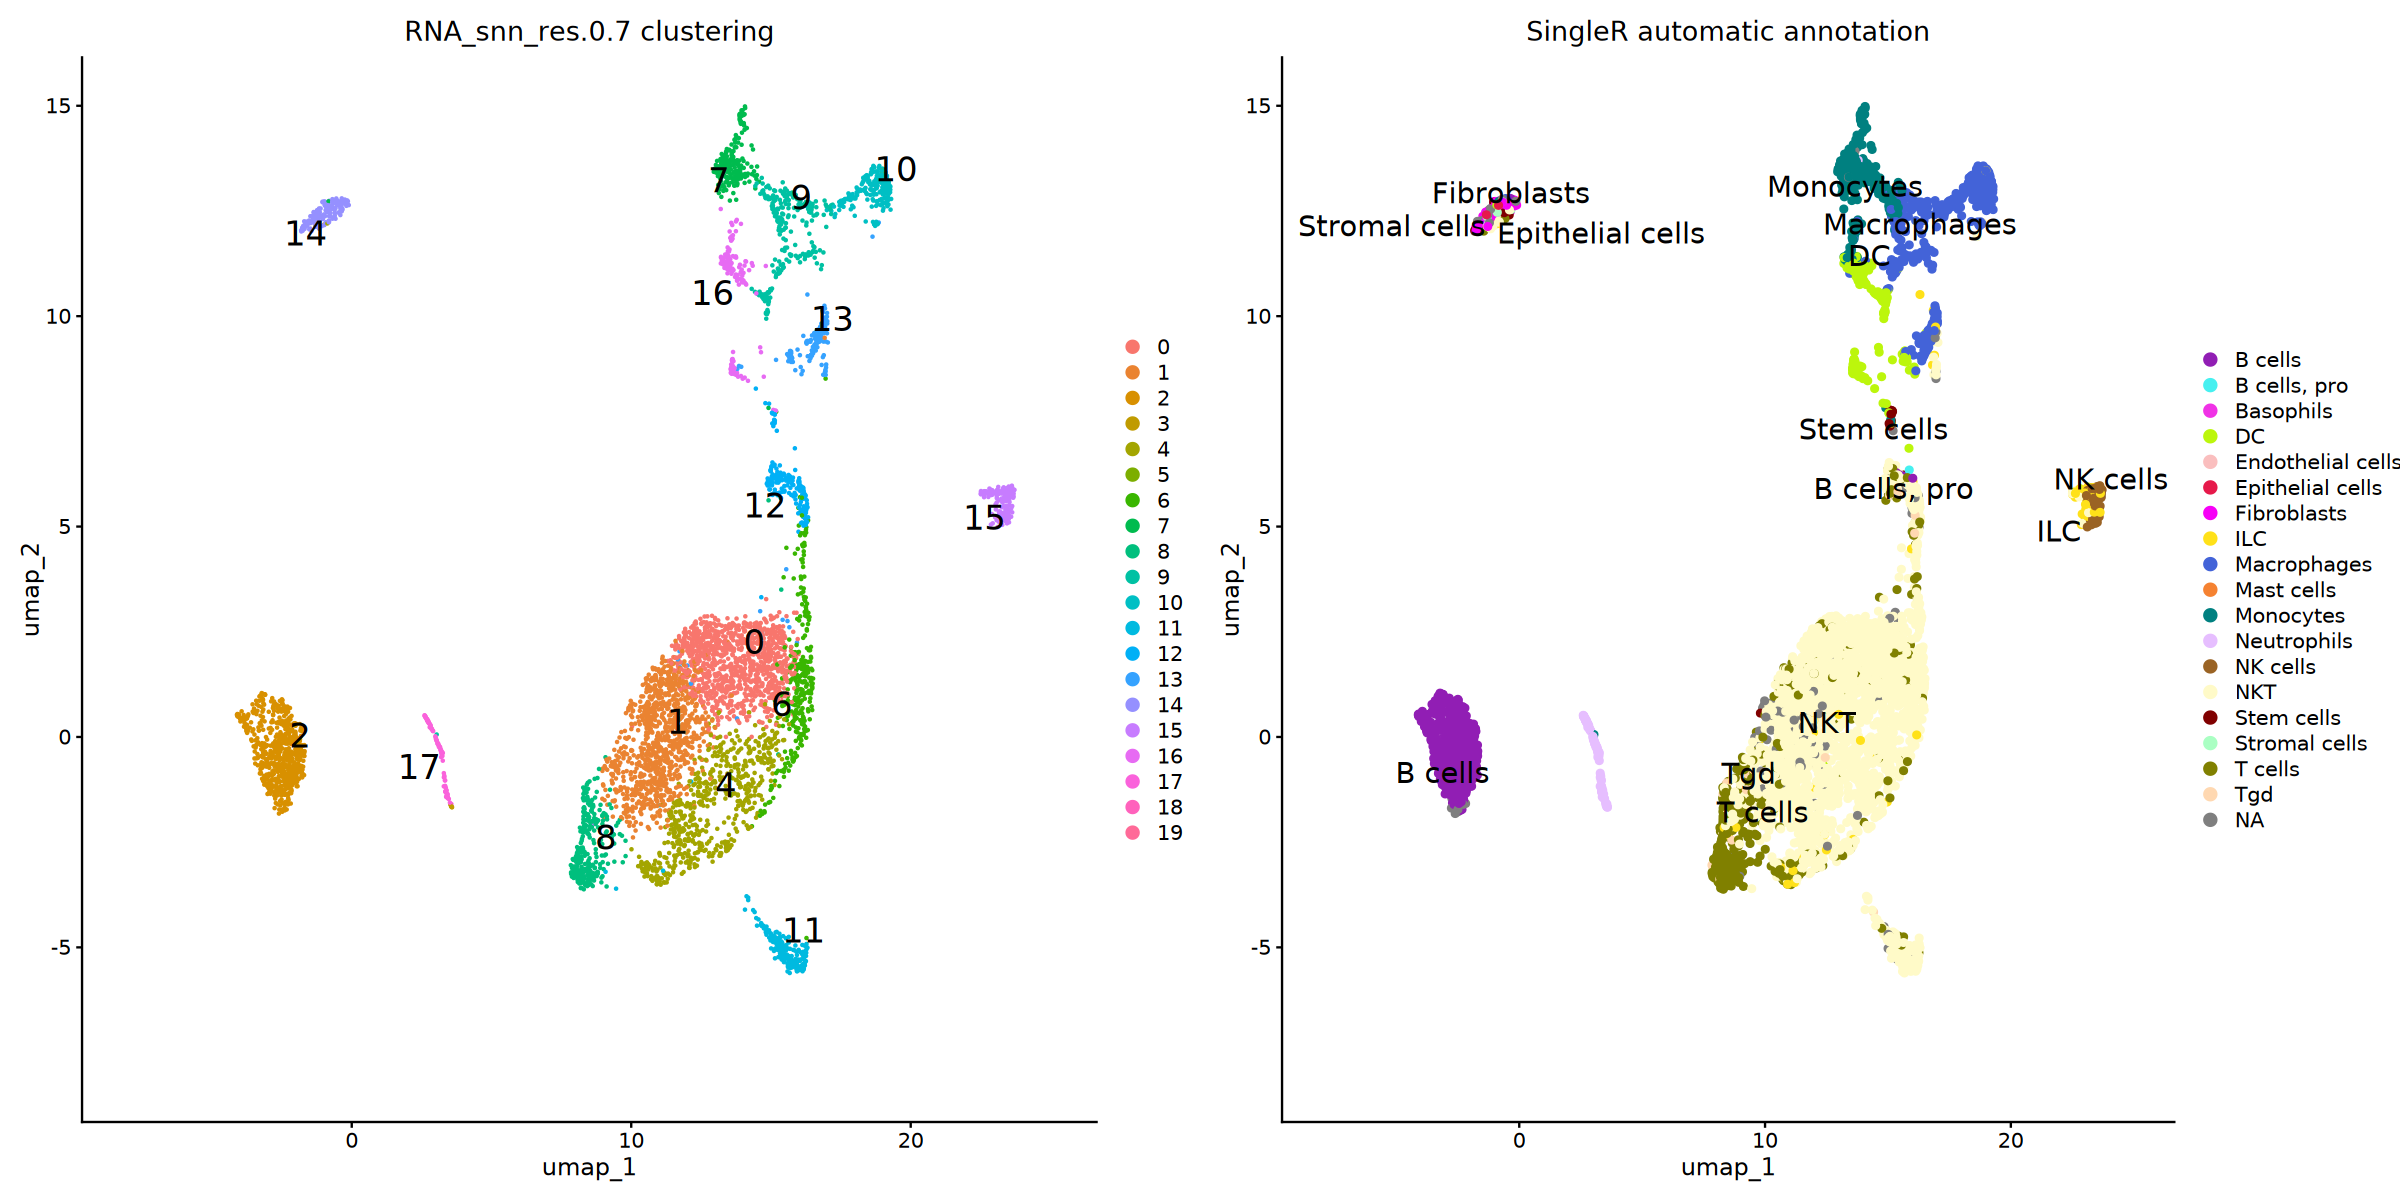

In [43]:
options(repr.plot.width=20, repr.plot.height=10)

Idents(seu)<-"RNA_snn_res.0.7"
ggarrange(
    UMAPPlot(seu, 
             group.by="RNA_snn_res.0.7", label=T, repel=T, label.size=7)+xlim(-8,25)+ylim(-8,15)+theme(legend.position = "right")+
    ggtitle("RNA_snn_res.0.7 clustering"),
    
    DimPlot(seu, 
         group.by="pred.immgen.mainpruned", label.size=6, 
         cols=c('#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                '#e6194b', '#F700F7', '#ffe119', '#4363d8', '#f58231',
                '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#4f34ff', '#f340F0'), 
         pt.size=1.5,label=T, repel=T)+xlim(-8,25)+ylim(-8,15)+theme(legend.position ="right")+
    ggtitle("SingleR automatic annotation"), 
    ncol=2, nrow=1
)

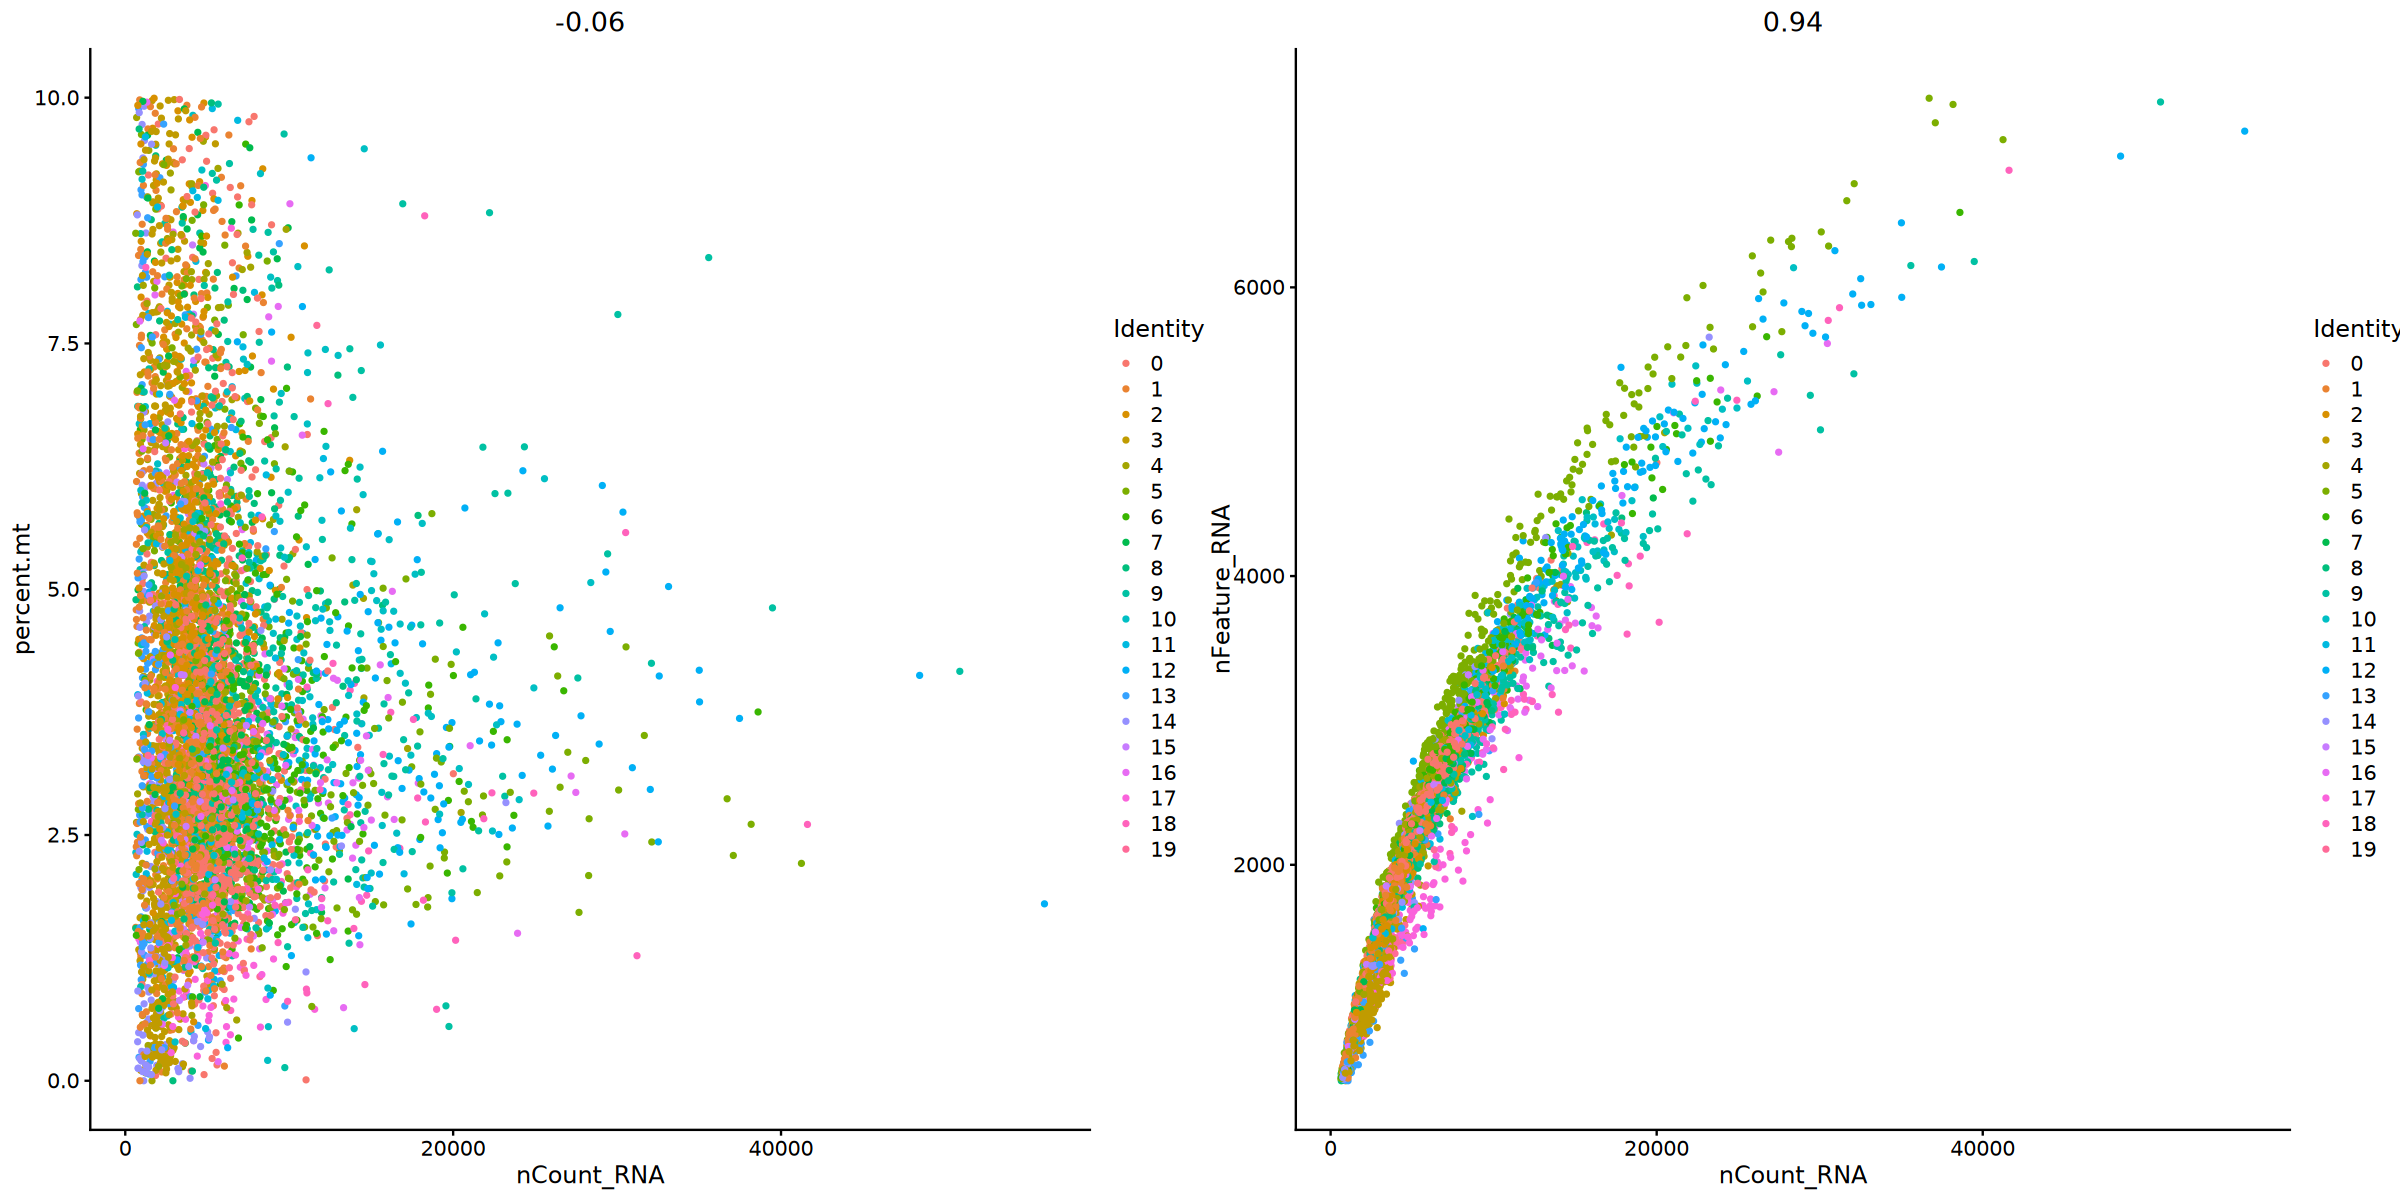

In [44]:
options(repr.plot.width=20, repr.plot.height=10)

ggarrange(ncol=2, nrow=1,
FeatureScatter(seu, feature1 = "nCount_RNA", "percent.mt"),
FeatureScatter(seu, feature1 = "nCount_RNA", "nFeature_RNA")
)

In [45]:
seu<-subset(seu, subset=nCount_RNA<40000)
seu<-subset(seu, subset=nFeature_RNA<7000)

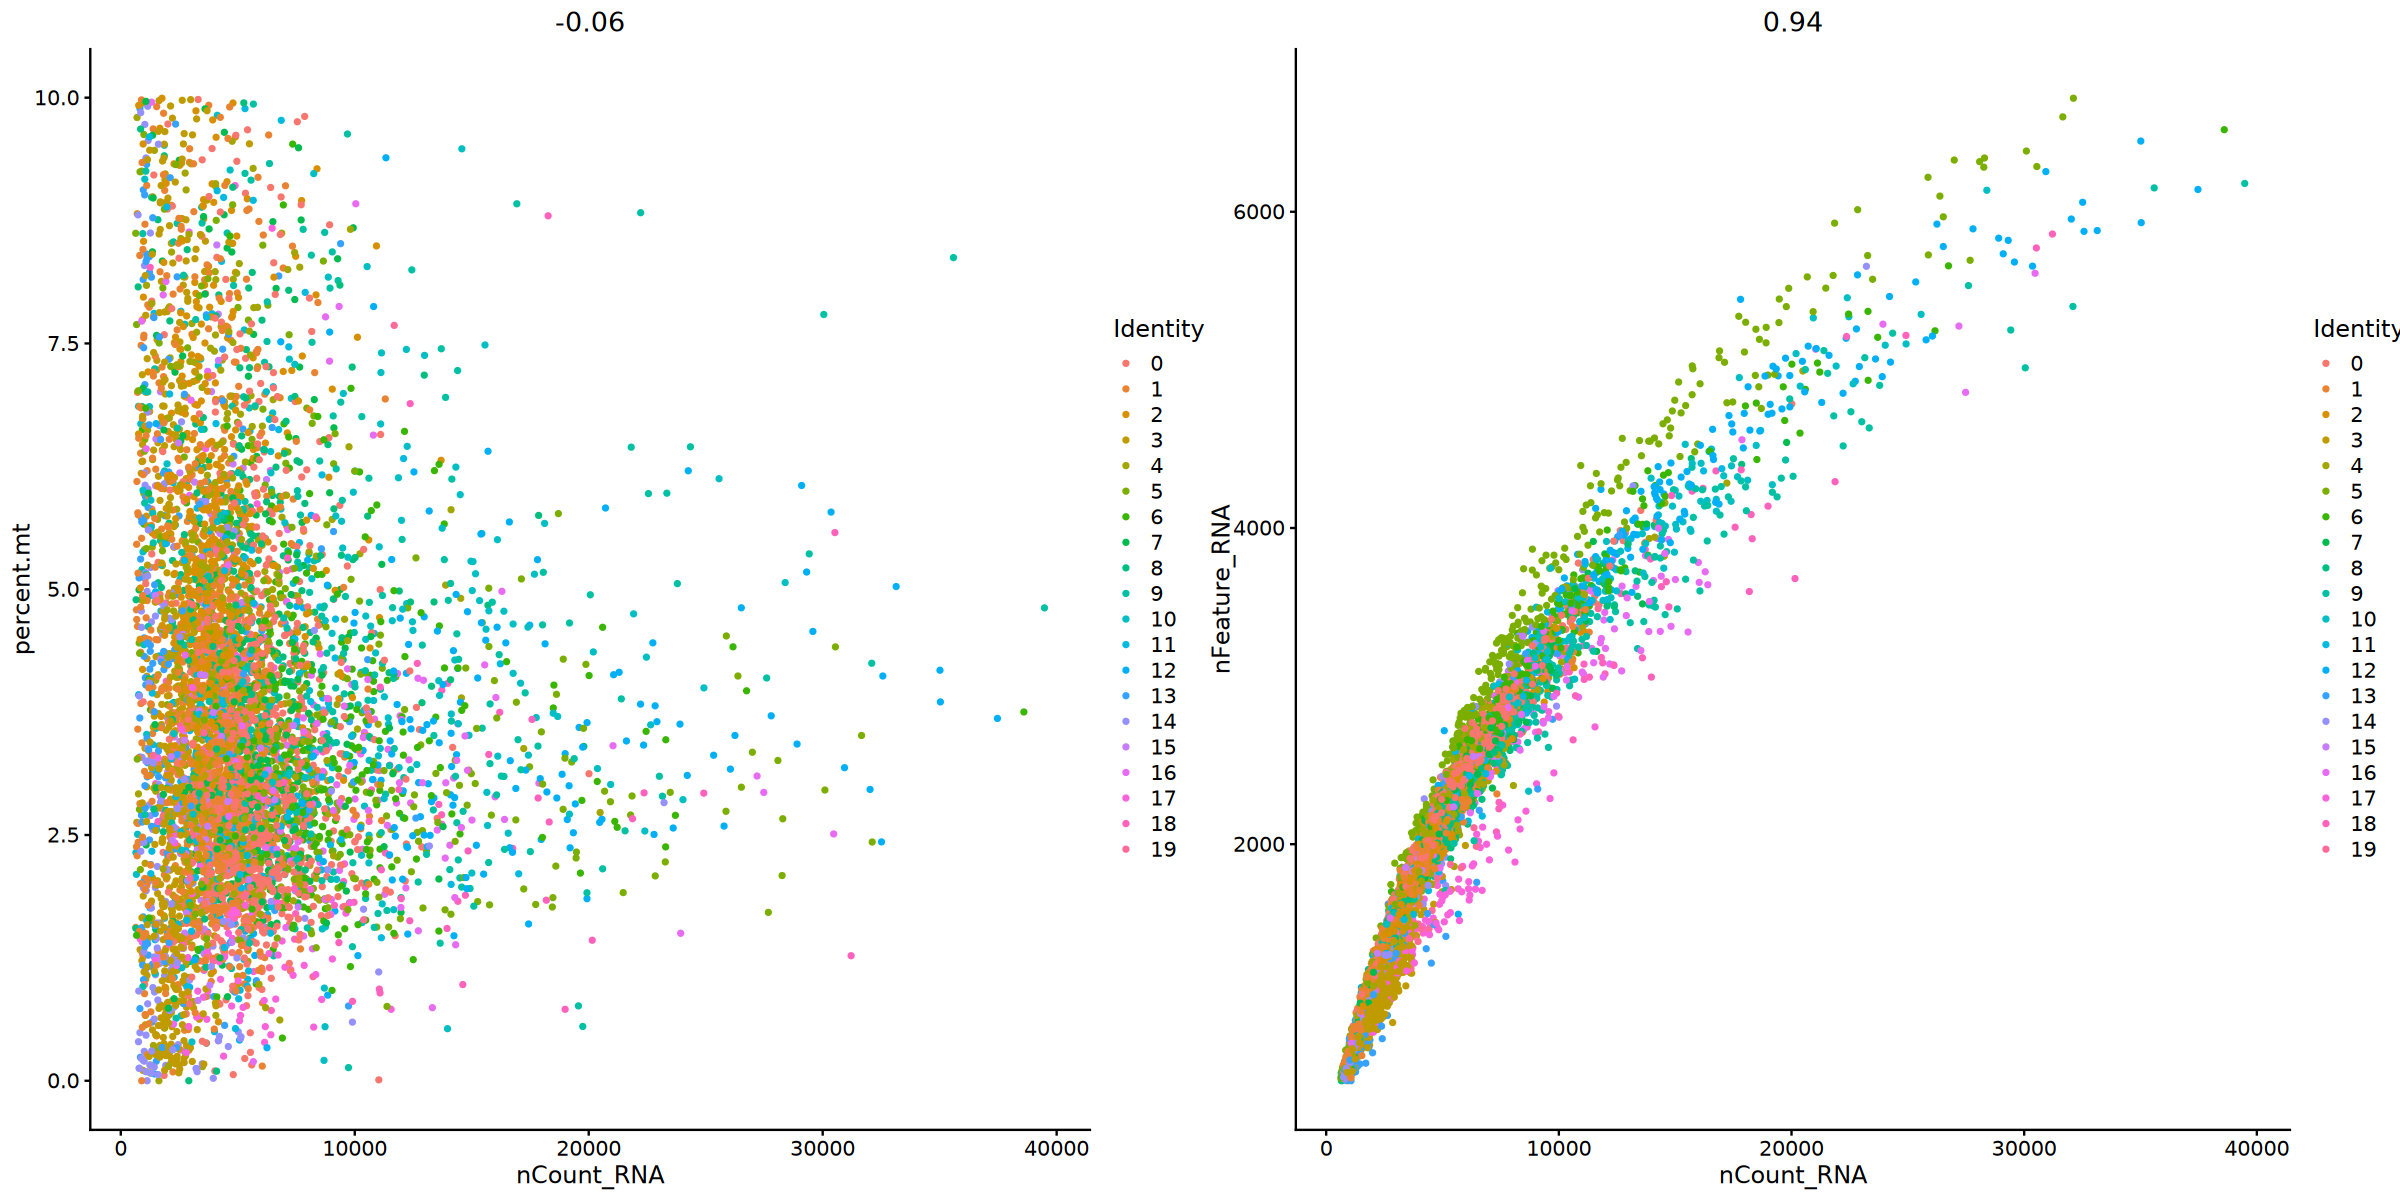

In [46]:
options(repr.plot.width=20, repr.plot.height=10)

ggarrange(ncol=2, nrow=1,
FeatureScatter(seu, feature1 = "nCount_RNA", "percent.mt"),
FeatureScatter(seu, feature1 = "nCount_RNA", "nFeature_RNA")
)

In [47]:
tic()
save(seu, file="/data3/Group8/gonglihao/1-MMP9/1-QC/shNC-singlet.rda", compress=T)
toc()

98.209 sec elapsed


In [48]:
tic()
saveRDS(seu, file = "/data3/Group8/gonglihao/1-MMP9/1-QC/shNC-singlet.rds")
toc()

99.246 sec elapsed
